In [1]:
import os
import sys
import glob
import time
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

In [2]:
from unet import UNet
from fcn import *
from utils import *
from dataset import *

In [3]:
DATA_DIR = 'data/IR-MNIST'
MODEL_PATH = './models/IR-MNIST/'
TRAIN_PATTERN = os.path.join(DATA_DIR, 'Train Samples/*.jpg')
train_paths = glob.glob(TRAIN_PATTERN)

# (224, 224)

## Training (noise, deep generator)

In [64]:
# hyperparams
gamma = 0.7
depth = 5
batch_size = 16
num_epochs = 20
print_intv = 1

In [65]:
MODEL_PATH = './models/IR-MNIST/gamma{:.1f}_depth{}/'.format(gamma, depth)
print(MODEL_PATH)
os.makedirs(MODEL_PATH, exist_ok=True)

./models/IR-MNIST/gamma0.7_depth5/


In [66]:
g_lr = 2e-4
d_lr = 1e-5

In [67]:
train_dataset = Dataset(train_paths)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

G = UNet(1, 1, depth=depth).to(device)
D = FCN_224_11(1).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=g_lr)
D_optimizer = optim.Adam(D.parameters(), lr=d_lr)
criterion = nn.BCELoss()

Epoch 0: 6.7min, D_loss: 1.393735, G_loss: 0.640139


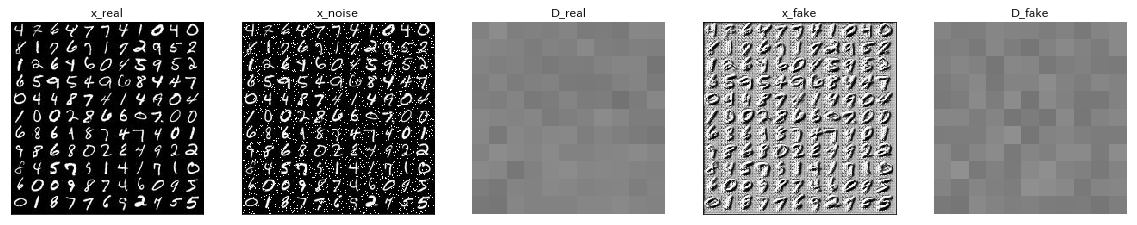

Epoch 1: 6.7min, D_loss: 1.386010, G_loss: 0.691108


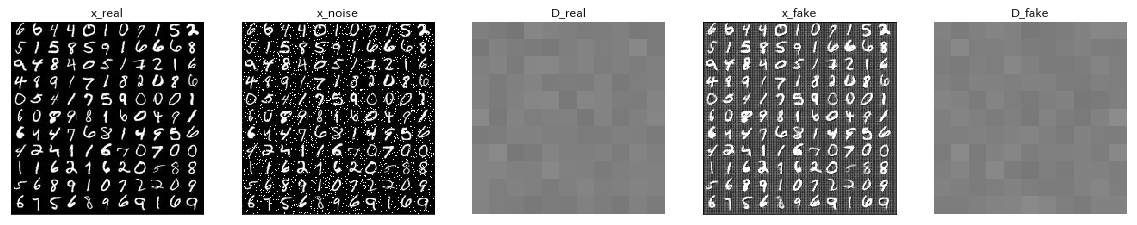

Epoch 2: 6.7min, D_loss: 1.387335, G_loss: 0.694620


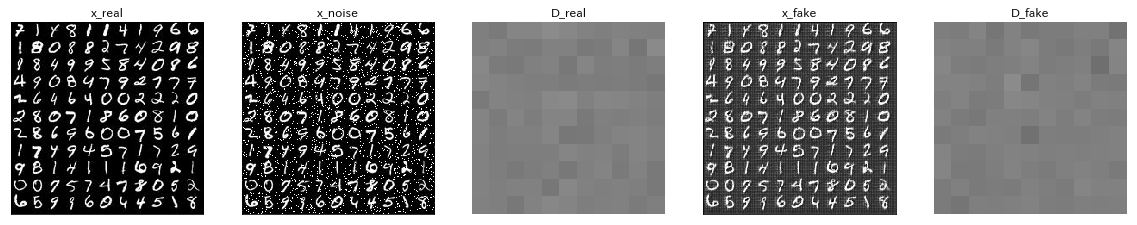

Epoch 3: 6.7min, D_loss: 1.385310, G_loss: 0.695636


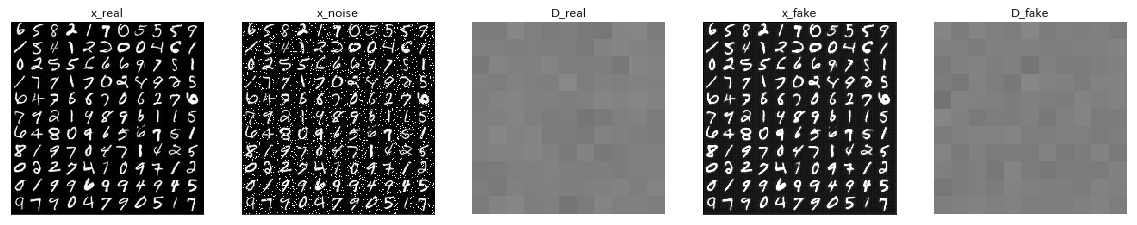

Epoch 4: 6.7min, D_loss: 1.379942, G_loss: 0.697409


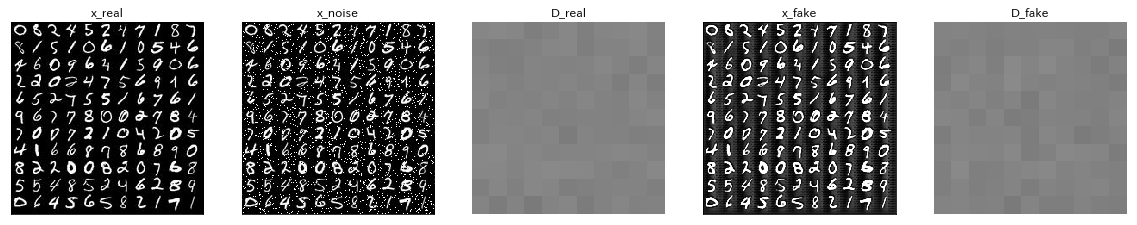

Epoch 5: 6.7min, D_loss: 1.301873, G_loss: 0.745331


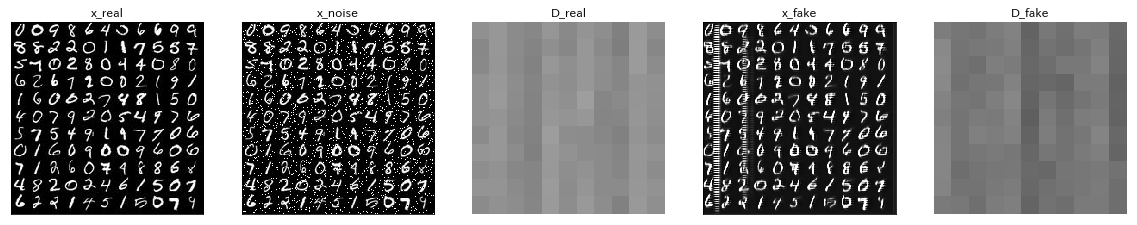

Epoch 6: 6.7min, D_loss: 1.049899, G_loss: 0.874388


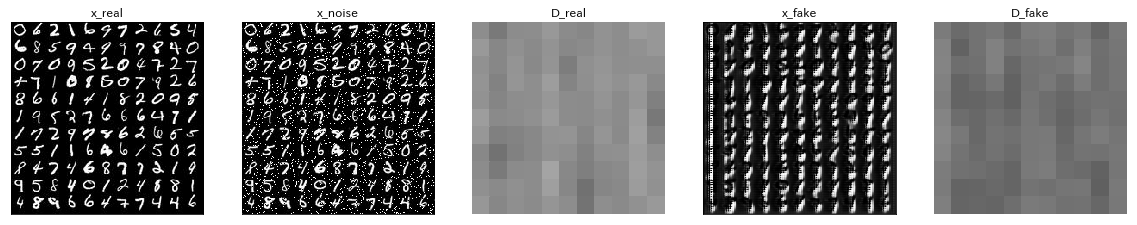

Epoch 7: 6.7min, D_loss: 0.919389, G_loss: 1.039451


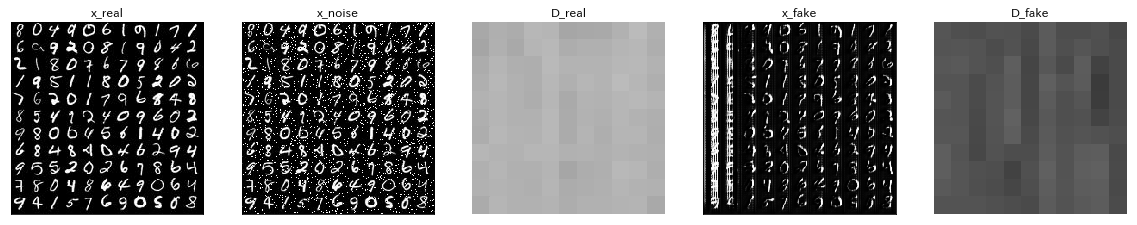

Epoch 8: 6.7min, D_loss: 0.700459, G_loss: 1.226250


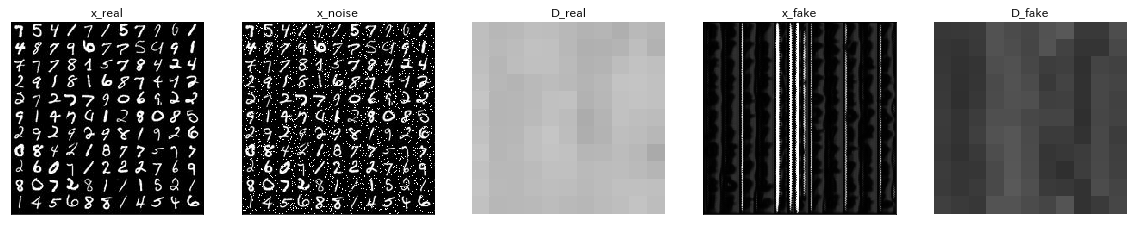

Epoch 9: 6.7min, D_loss: 0.641130, G_loss: 1.315257


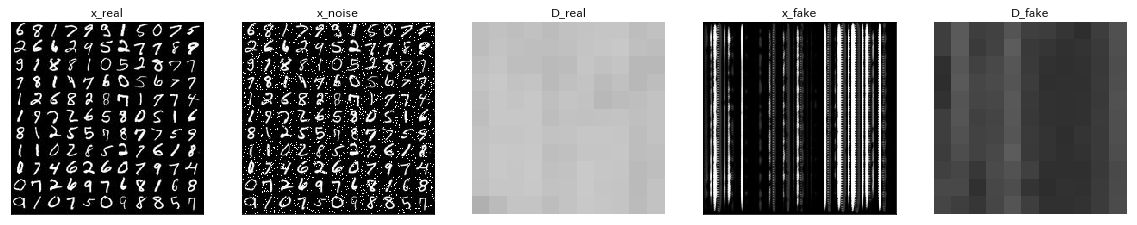

Epoch 10: 6.7min, D_loss: 0.555195, G_loss: 1.462167


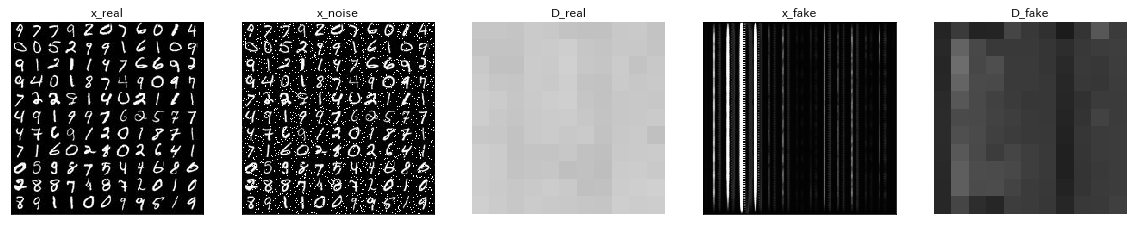

Epoch 11: 6.7min, D_loss: 0.452666, G_loss: 1.655308


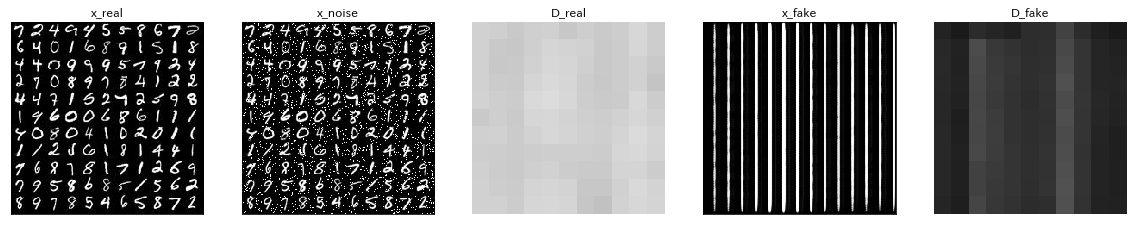

Epoch 12: 6.7min, D_loss: 0.385554, G_loss: 1.787704


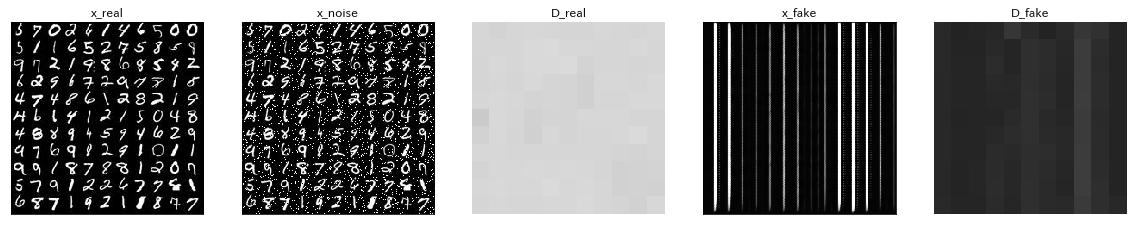

Epoch 13: 6.7min, D_loss: 0.386278, G_loss: 1.755405


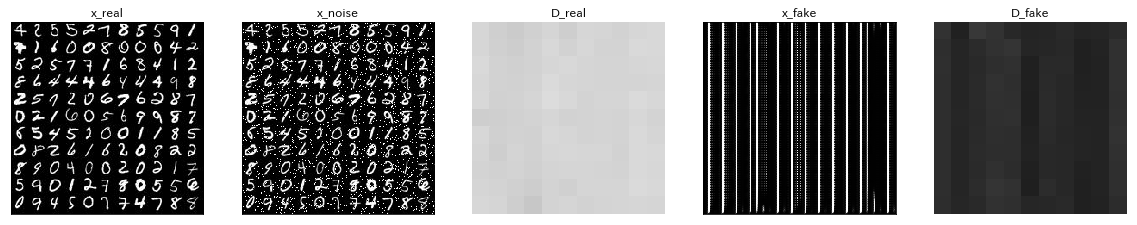

Epoch 14: 6.7min, D_loss: 0.336694, G_loss: 1.947743


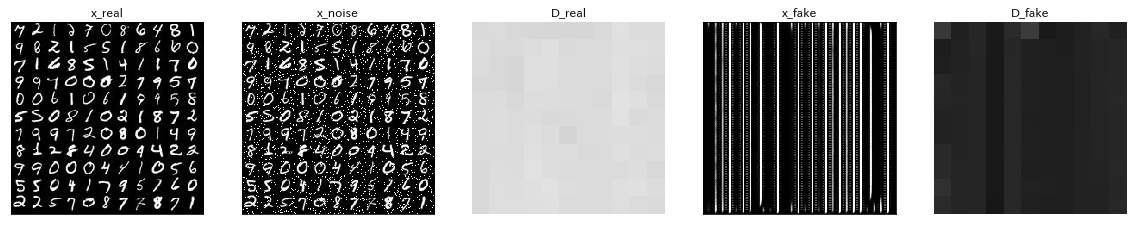

Epoch 15: 6.7min, D_loss: 0.298439, G_loss: 2.020001


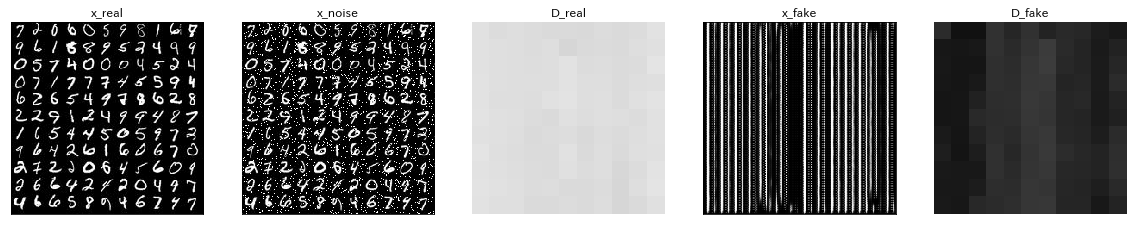

Epoch 16: 6.7min, D_loss: 0.297497, G_loss: 2.069085


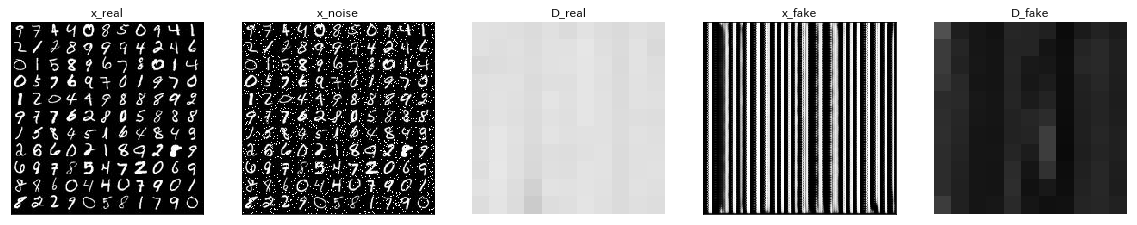

Epoch 17: 6.7min, D_loss: 0.261403, G_loss: 2.193455


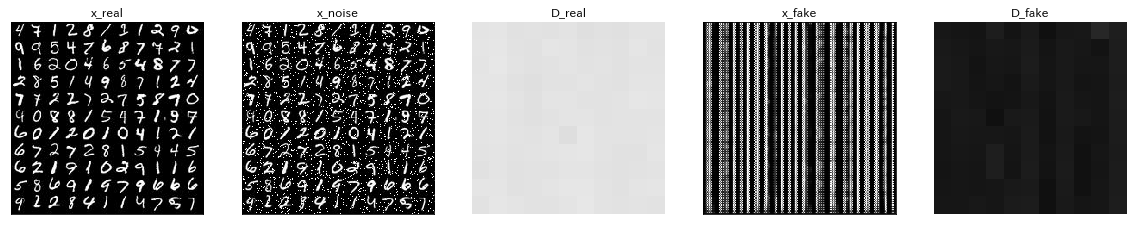

Epoch 18: 6.8min, D_loss: 0.226278, G_loss: 2.288261


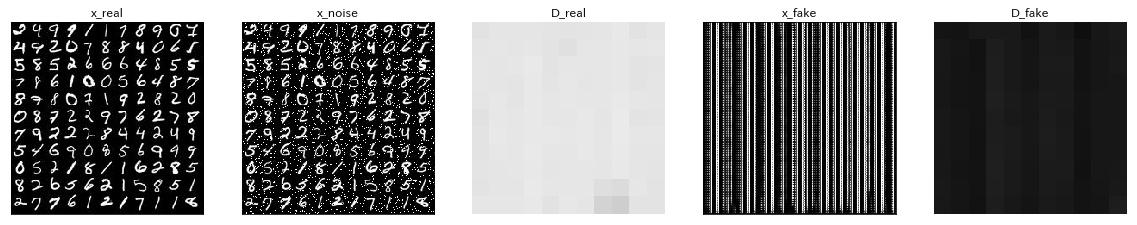

Epoch 19: 6.8min, D_loss: 0.210632, G_loss: 2.371149


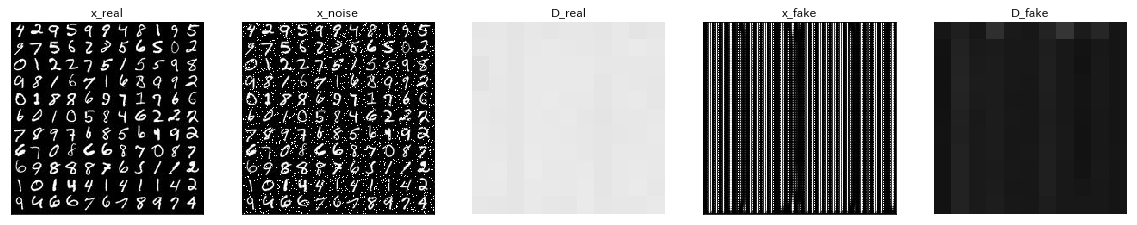

In [68]:
# Training
history = {'D_loss': [], 'G_loss': []}

D.train()
G.train()
D_best_loss = np.inf
G_best_loss = np.inf

for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    _D_real_loss = 0
    _D_fake_loss = 0
    
    start = time.time()
    for x_real in train_loader:

        D.zero_grad()
        G.zero_grad()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        x_real = x_real.to(device) 

        ### Update Discriminator ###
        # real
        D_real = D(x_real)
        y_real = torch.ones(D_real.size()).to(device)
        y_fake = torch.zeros(D_real.size()).to(device)
        D_real_loss = criterion(D_real, y_real)
        
        # fake
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 127.5
        x_fake = G(x_noise)
        D_fake = D(x_fake.detach())  # detach for computational speed
        D_fake_loss = criterion(D_fake, y_fake)
        
        # update params
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        # for debug
        _D_real_loss += D_real_loss.item()
        _D_fake_loss += D_fake_loss.item()
        
        ### Update Generator ###
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 127.5
        x_fake = G(x_noise)
        D_fake = D(x_fake)
        
        # update params
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
    elapsed_time = (time.time() - start) / 60
    
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    history['D_loss'].append(D_running_loss)
    history['G_loss'].append(G_running_loss)
    
    
    torch.save(D.state_dict(), MODEL_PATH+'D_{:03d}.pth'.format(epoch))
    torch.save(G.state_dict(), MODEL_PATH+'G_{:03d}.pth'.format(epoch))
    if D_running_loss < D_best_loss:
        D_best_loss = D_running_loss
        torch.save(D.state_dict(), MODEL_PATH+'D.pth'.format(epoch))
    if G_running_loss < G_best_loss:
        G_best_loss = G_running_loss
        torch.save(G.state_dict(), MODEL_PATH+'G.pth')
    
    print('Epoch {}: {:.1f}min, D_loss: {:.6f}, G_loss: {:.6f}'.format(epoch, elapsed_time, D_running_loss, G_running_loss))
    
    if epoch % print_intv == 0:
        imgs = {
            'x_real': tanh2sigmoid(x_real),
            'x_noise': tanh2sigmoid(x_noise),
            'D_real': D_real,
            'x_fake': tanh2sigmoid(x_fake),
            'D_fake': D_fake,
        }
        idxs = np.random.randint(0, x_real.size(0), [1])
        show_imgs(imgs, idxs)

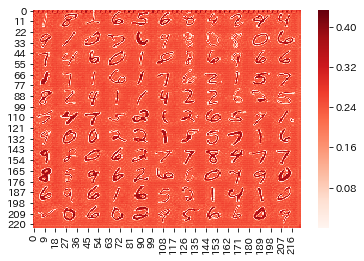

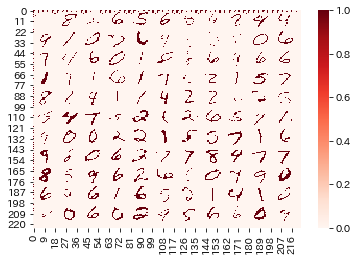

In [14]:
# G.load_state_dict(torch.load(MODEL_PATH + 'G.pth'))
# D.load_state_dict(torch.load(MODEL_PATH + 'D.pth'))
x_fake = G(x_real)
diff = torch.abs(x_real-x_fake)
heat = diff.data.cpu().numpy()[0,0]
sns.heatmap(heat, cmap='Reds')
plt.show()
sns.heatmap(heat>0.3, cmap='Reds')
plt.show()

## Training (noise, deep generator, L2)

In [23]:
# hyperparams
gamma = 0.7
depth = 5
batch_size = 16
num_epochs = 30
print_intv = 1

In [24]:
MODEL_PATH = './models/IR-MNIST/L2_gamma{:.1f}_depth{}/'.format(gamma, depth)
print(MODEL_PATH)
os.makedirs(MODEL_PATH, exist_ok=True)

./models/IR-MNIST/L2_gamma0.7_depth5/


In [25]:
g_lr = 2e-4
d_lr = 1e-5

In [26]:
def torch_log(x, eps=1e-12):
    return torch.log(torch.clamp(x, eps, 1.))

def l2_BCE(y, t, eps=1e-12):
    return -(t*torch_log(y**2) + (1-t)*torch_log((1-y)**2)).mean()

In [40]:
train_dataset = Dataset(train_paths)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

G = UNet(1, 1, depth=depth).to(device)
D = FCN_224_11(1).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=g_lr)
D_optimizer = optim.Adam(D.parameters(), lr=d_lr)
# criterion = nn.BCEWithLogitsLoss()
criterion = l2_BCE

Epoch 0: 6.7min, D_loss: 2.779111, G_loss: 1.410397


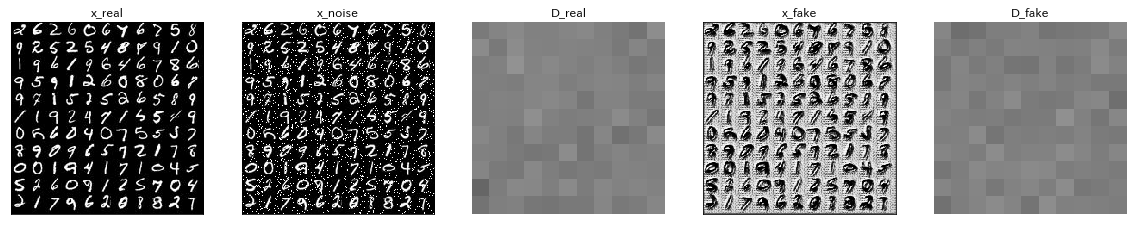

Epoch 1: 6.7min, D_loss: 2.748259, G_loss: 1.395414


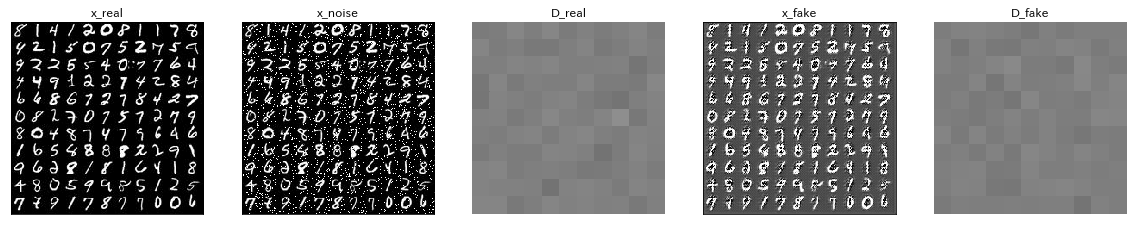

Epoch 2: 6.7min, D_loss: 2.778331, G_loss: 1.393119


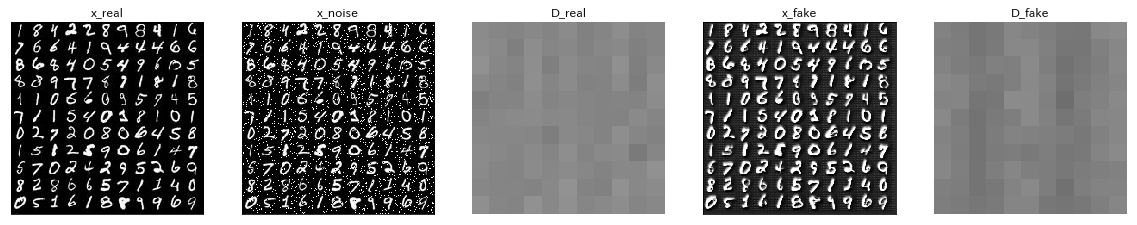

Epoch 3: 6.7min, D_loss: 2.766221, G_loss: 1.394005


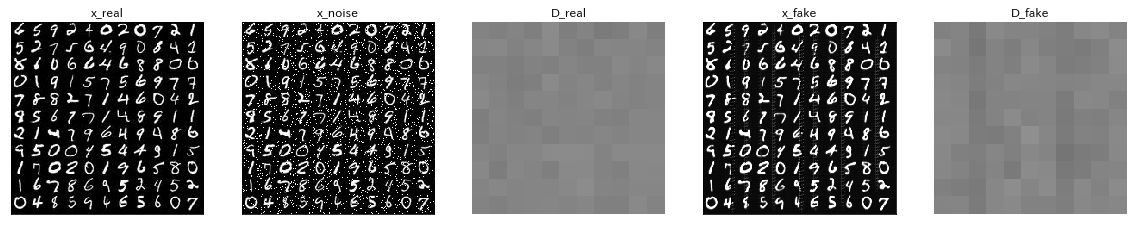

Epoch 4: 6.7min, D_loss: 2.772506, G_loss: 1.397456


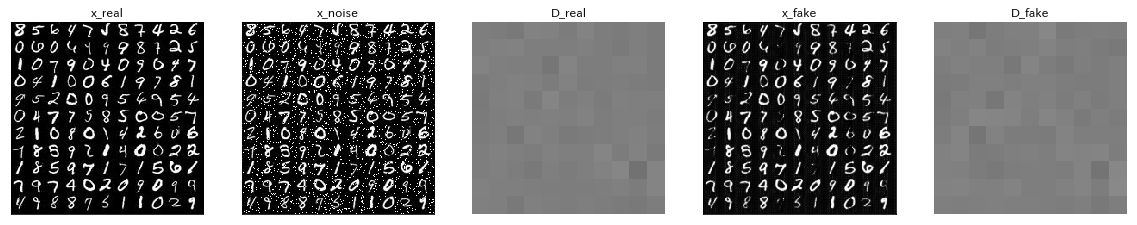

Epoch 5: 6.7min, D_loss: 2.778893, G_loss: 1.385106


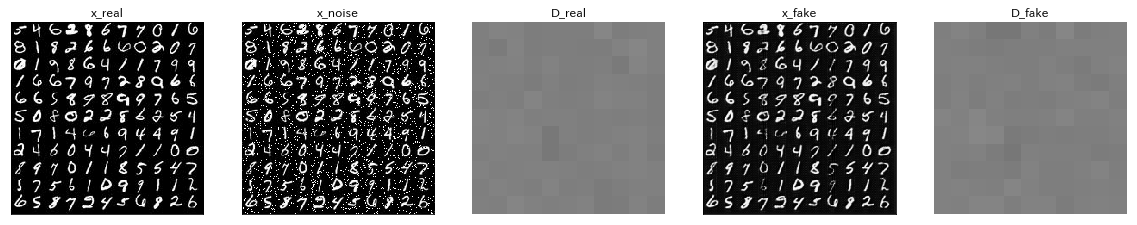

Epoch 6: 6.7min, D_loss: 2.774578, G_loss: 1.387237


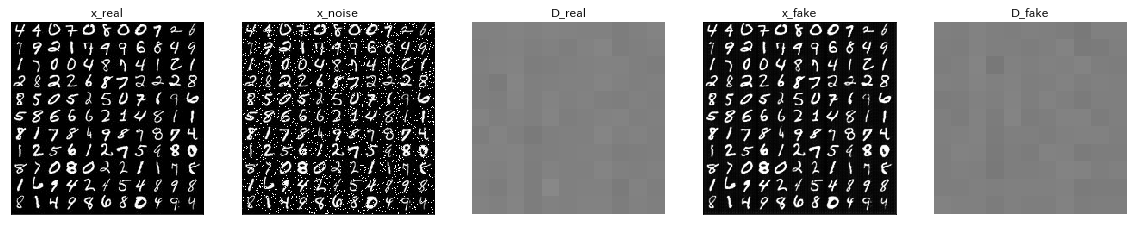

Epoch 7: 6.7min, D_loss: 2.778054, G_loss: 1.387722


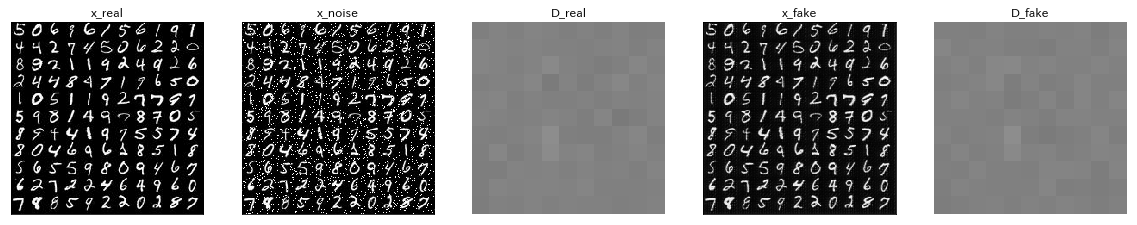

Epoch 8: 6.7min, D_loss: 2.775202, G_loss: 1.387545


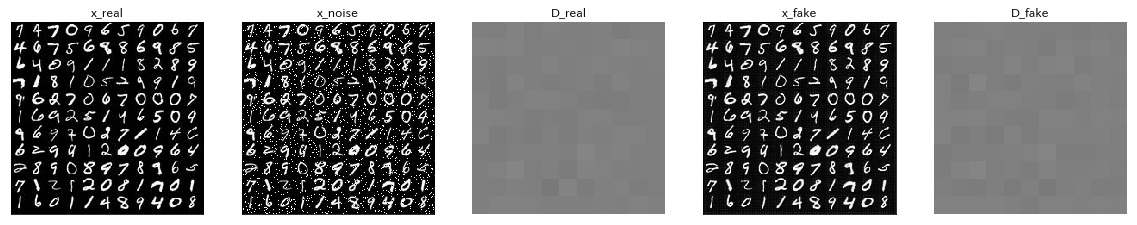

Epoch 9: 6.7min, D_loss: 2.774755, G_loss: 1.386969


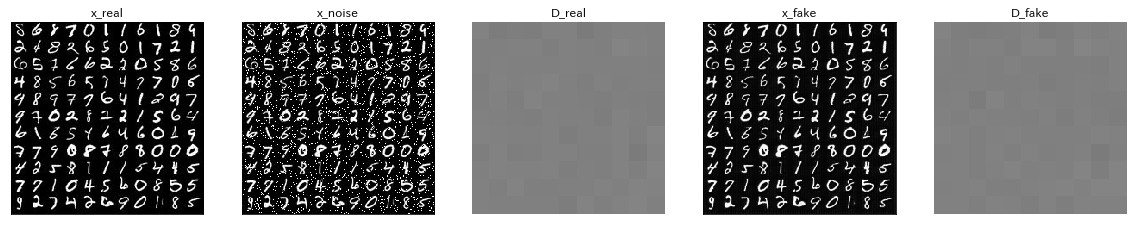

Epoch 10: 6.7min, D_loss: 2.774476, G_loss: 1.385247


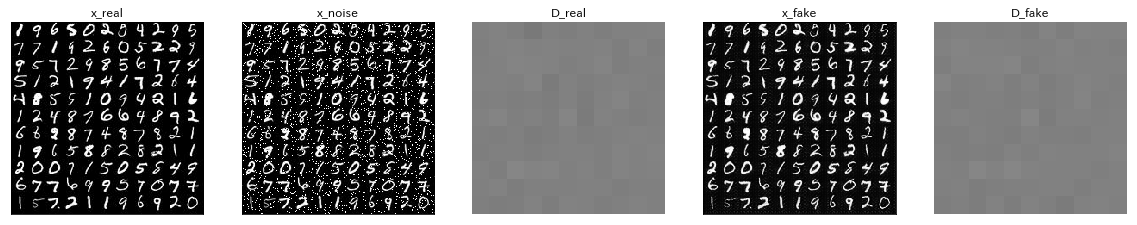

KeyboardInterrupt: 

In [41]:
# Training
history = {'D_loss': [], 'G_loss': []}

D.train()
G.train()
D_best_loss = np.inf
G_best_loss = np.inf

for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    _D_real_loss = 0
    _D_fake_loss = 0
    
    start = time.time()
    for x_real in train_loader:

        D.zero_grad()
        G.zero_grad()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        x_real = x_real.to(device) 

        ### Update Discriminator ###
        # real
        D_real = D(x_real)
        y_real = torch.ones(D_real.size()).to(device)
        y_fake = torch.zeros(D_real.size()).to(device)
        D_real_loss = criterion(D_real, y_real)
        
        # fake
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 127.5
        x_fake = G(x_noise)
        D_fake = D(x_fake.detach())  # detach for computational speed
        D_fake_loss = criterion(D_fake, y_fake)
        
        # update params
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        # for debug
        _D_real_loss += D_real_loss.item()
        _D_fake_loss += D_fake_loss.item()
        
        ### Update Generator ###
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 127.5
        x_fake = G(x_noise)
        D_fake = D(x_fake)
        
        # update params
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
    elapsed_time = (time.time() - start) / 60
    
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    history['D_loss'].append(D_running_loss)
    history['G_loss'].append(G_running_loss)
    
    
    torch.save(D.state_dict(), MODEL_PATH+'D_{:03d}.pth'.format(epoch))
    torch.save(G.state_dict(), MODEL_PATH+'G_{:03d}.pth'.format(epoch))
    if D_running_loss < D_best_loss:
        D_best_loss = D_running_loss
        torch.save(D.state_dict(), MODEL_PATH+'D.pth'.format(epoch))
    if G_running_loss < G_best_loss:
        G_best_loss = G_running_loss
        torch.save(G.state_dict(), MODEL_PATH+'G.pth')
    
    print('Epoch {}: {:.1f}min, D_loss: {:.6f}, G_loss: {:.6f}'.format(epoch, elapsed_time, D_running_loss, G_running_loss))
    
    if epoch % print_intv == 0:
        imgs = {
            'x_real': tanh2sigmoid(x_real),
            'x_noise': tanh2sigmoid(x_noise),
            'D_real': D_real,
            'x_fake': tanh2sigmoid(x_fake),
            'D_fake': D_fake,
        }
        idxs = np.random.randint(0, x_real.size(0), [1])
        show_imgs(imgs, idxs)

## 推論

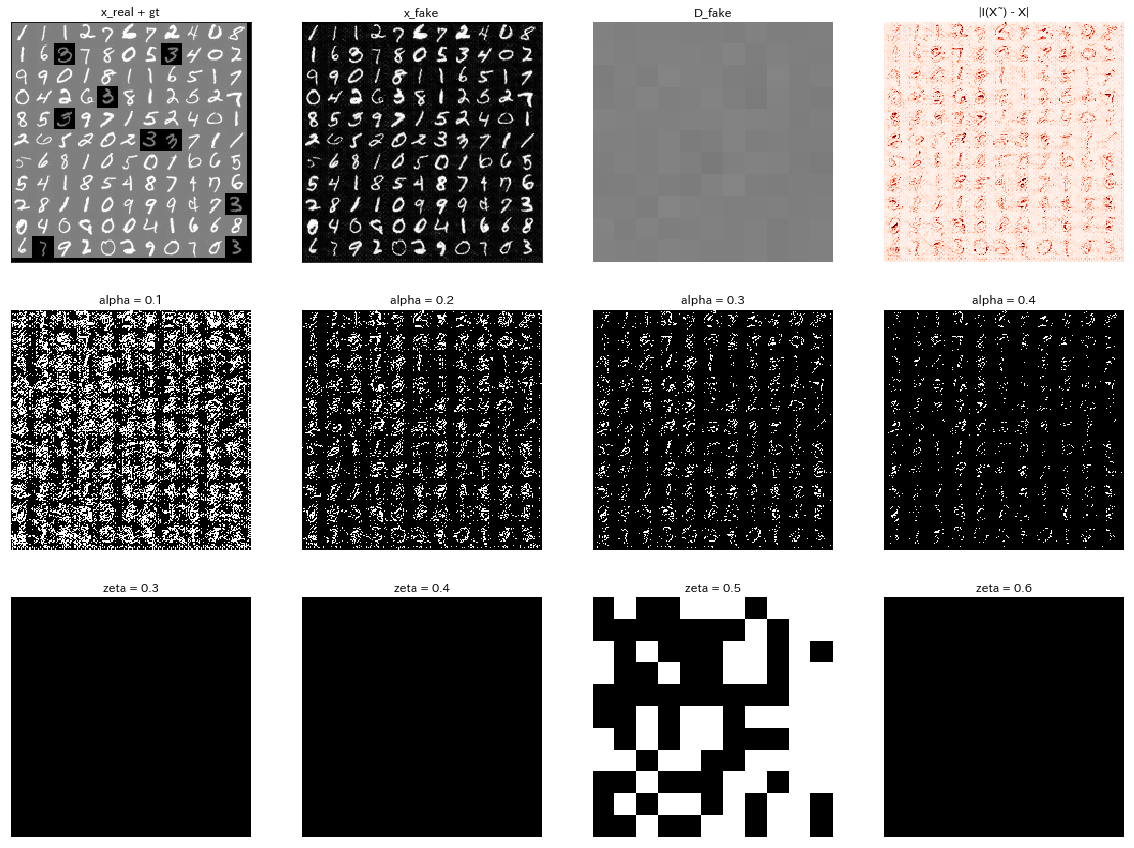

In [62]:
real_path = DATA_DIR + '/Test Samples/image_100.jpg'
gt_path = real_path.replace('Test Samples', 'GT').replace('image', 'gt_image')
real_img = Image.open(real_path).convert('L')
gt_img = Image.open(gt_path)
x_real = train_dataset.transform(real_img).unsqueeze(0).to(device)

# G.load_state_dict(torch.load(MODEL_PATH + 'G.pth'))
# D.load_state_dict(torch.load(MODEL_PATH + 'D.pth'))
x_real = x_real.to(device)
x_fake = G(x_real)
# x_fake = G(x_real + 30*torch.randn(x_real.size()).to(device)/127.5)
D_fake = D(x_fake)

plt.figure(figsize=(20,15))

# real + gt
ax = plt.subplot(3, 4, 1)
ax.imshow(real_img, cmap='gray')
ax.imshow(gt_img, alpha=0.5, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('x_real + gt')

# fake
ax = plt.subplot(3, 4, 2)
ano_img = transforms.ToPILImage()(tanh2sigmoid(x_fake).cpu()[0])
ax.imshow(ano_img, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('x_fake')

# D_fake
_D_fake = D_fake[0,0].data.cpu().numpy()
ax = plt.subplot(3, 4, 3)
sns.heatmap(_D_fake, vmin=0, vmax=1, cmap='gray', ax=ax, square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('D_fake')

# heat
ax = plt.subplot(3, 4, 4)
diff = torch.abs(x_real-x_fake)
heat = diff.data.cpu().numpy()[0,0]
sns.heatmap(heat, ax=ax, cmap='Reds', vmin=0, vmax=1, square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('|I(X~) - X|')

# |I(X~)-X| threshold
ax = plt.subplot(3, 4, 5)
sns.heatmap(heat>0.1, ax=ax, cmap='gray', square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('alpha = {:.1f}'.format(0.1))
ax = plt.subplot(3, 4, 6)
sns.heatmap(heat>0.2, ax=ax, cmap='gray', square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('alpha = {:.1f}'.format(0.2))
ax = plt.subplot(3, 4, 7)
sns.heatmap(heat>0.3, ax=ax, cmap='gray', square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('alpha = {:.1f}'.format(0.3))
ax = plt.subplot(3, 4, 8)
sns.heatmap(heat>0.4, ax=ax, cmap='gray', square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('alpha = {:.1f}'.format(0.4))

# D_fake threshold
ax = plt.subplot(3, 4, 9)
sns.heatmap(_D_fake<0.3, ax=ax, cmap='gray', square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('zeta = {:.1f}'.format(0.3))
ax = plt.subplot(3, 4, 10)
sns.heatmap(_D_fake<0.4, ax=ax, cmap='gray', square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('zeta = {:.1f}'.format(0.4))
ax = plt.subplot(3, 4, 11)
sns.heatmap(_D_fake<0.5, ax=ax, cmap='gray', square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('zeta = {:.1f}'.format(0.5))
ax = plt.subplot(3, 4, 12)
sns.heatmap(_D_fake<0.6, ax=ax, cmap='gray', square=True, cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('zeta = {:.1f}'.format(0.6))

plt.show()

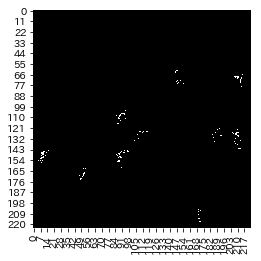

In [63]:
resized_D_fake = np.array(convert_tensor_to_PIL(D_fake[0].cpu()).resize([224,224]))/255
mask = (heat>0.4)*(resized_D_fake<0.49)
sns.heatmap(mask, cmap='gray', square=True, cbar=False)